In [54]:
import sys
print(sys.version)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 16

# https://www.kaggle.com/magiclantern/co2-emission-forecast-with-python-arima-v2

3.7.10 | packaged by conda-forge | (default, Oct  5 2021, 16:59:49) 
[Clang 11.1.0 ]


In [55]:
import warnings
import itertools
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [56]:
df = pd.read_csv("data/MER_T12_06.csv")
df.head()

MSN  YYYYMM   Value  Column_Order  \
0  CLEIEUS  197301  72.076             1   
1  CLEIEUS  197302  64.442             1   
2  CLEIEUS  197303  64.084             1   
3  CLEIEUS  197304  60.842             1   
4  CLEIEUS  197305  61.798             1   

                                Description  \
0  Coal Electric Power Sector CO2 Emissions   
1  Coal Electric Power Sector CO2 Emissions   
2  Coal Electric Power Sector CO2 Emissions   
3  Coal Electric Power Sector CO2 Emissions   
4  Coal Electric Power Sector CO2 Emissions   

                                    Unit  
0  Million Metric Tons of Carbon Dioxide  
1  Million Metric Tons of Carbon Dioxide  
2  Million Metric Tons of Carbon Dioxide  
3  Million Metric Tons of Carbon Dioxide  
4  Million Metric Tons of Carbon Dioxide

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSN           5094 non-null   object
 1   YYYYMM        5094 non-null   int64 
 2   Value         5094 non-null   object
 3   Column_Order  5094 non-null   int64 
 4   Description   5094 non-null   object
 5   Unit          5094 non-null   object
dtypes: int64(2), object(4)
memory usage: 238.9+ KB


The dataset has 6 columns where 2 of them are integer data type and 4 objects and 5096 observations. The above dataset retriving method only retrives the dataset as a dataframe that is not as a time series dataset. To read the dataset as a time series, we have to pass special arguments to the read_csv command as given below.

In [58]:
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')

df = pd.read_csv("data/MER_T12_06.csv", parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 
df.head()

MSN   Value  Column_Order  \
YYYYMM                                      
1973-01-01  CLEIEUS  72.076             1   
1973-02-01  CLEIEUS  64.442             1   
1973-03-01  CLEIEUS  64.084             1   
1973-04-01  CLEIEUS  60.842             1   
1973-05-01  CLEIEUS  61.798             1   

                                         Description  \
YYYYMM                                                 
1973-01-01  Coal Electric Power Sector CO2 Emissions   
1973-02-01  Coal Electric Power Sector CO2 Emissions   
1973-03-01  Coal Electric Power Sector CO2 Emissions   
1973-04-01  Coal Electric Power Sector CO2 Emissions   
1973-05-01  Coal Electric Power Sector CO2 Emissions   

                                             Unit  
YYYYMM                                             
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-03-01  Million Metric Tons of Carbon Dioxide  
1973-04-01  Million Metric Tons of Carbon Dioxide  
1973-05-01  Million Metric Tons of Carbon Dioxide

The arguments can be explained:

* parse_dates: This is a key to identify the date time column. Example, the column name is ‘YYYYMM’.
* index_col: This is a key that forces pandas to use the date time column as index.
* date_parser: Converts an input string into datetime variable.

Total sum of CO2 emission from each energy group for every year is given as an observation that can be viewed in the NaT row. So, let us first identify and drop the non datetimeindex rows and also use ts to refere the time series dataset instead of the dataframe df. First, let us convert the index to datetime, coerce errors, and filter NaT

In [59]:
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]

In [60]:
ts['Value'] = pd.to_numeric(ts['Value'] , errors='coerce')
print(ts.shape)
ts.info()

(4707, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4707 entries, 1973-01-01 to 2016-07-01
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSN           4707 non-null   object 
 1   Value         4323 non-null   float64
 2   Column_Order  4707 non-null   int64  
 3   Description   4707 non-null   object 
 4   Unit          4707 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 220.6+ KB


In [61]:
ts.dropna(inplace = True)
print(ts.shape)

(4323, 5)


In [62]:
Energy_sources = ts.groupby('Description')
Energy_sources.head(2)

MSN    Value  Column_Order  \
YYYYMM                                       
1973-01-01  CLEIEUS   72.076             1   
1973-02-01  CLEIEUS   64.442             1   
1973-01-01  NNEIEUS   12.175             2   
1973-02-01  NNEIEUS   11.708             2   
1973-01-01  DKEIEUS    2.375             3   
1973-02-01  DKEIEUS    2.061             3   
1973-01-01  PCEIEUS    0.128             4   
1973-02-01  PCEIEUS    0.106             4   
1973-01-01  RFEIEUS   24.867             5   
1973-02-01  RFEIEUS   20.867             5   
1973-01-01  PAEIEUS   27.369             6   
1973-02-01  PAEIEUS   23.034             6   
1989-01-01  GEEIEUS    0.031             7   
1989-02-01  GEEIEUS    0.028             7   
1989-01-01  NWEIEUS    0.371             8   
1989-02-01  NWEIEUS    0.335             8   
1973-01-01  TXEIEUS  111.621             9   
1973-02-01  TXEIEUS   99.185             9   

                                                  Description  \
YYYYMM                                                          
1973-01-01           Coal Electric Power Sector CO2 Emissions   
1973-02-01           Coal Electric Power Sector CO2 Emissions   
1973-01-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-02-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-01-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-02-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-01-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-02-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-01-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-02-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-01-01      Petroleum Electric Power Sector CO2 Emissions   
1973-02-01      Petroleum Electric Power Sector CO2 Emissions   
1989-01-01  Geothermal Energy Electric Power Sector CO2 Em...   
1989-02-01  Geothermal Energy Electric Power Sector CO2 Em...   
1989-01-01  Non-Biomass Waste Electric Power Sector CO2 Em...   
1989-02-01  Non-Biomass Waste Electric Power Sector CO2 Em...   
1973-01-01   Total Energy Electric Power Sector CO2 Emissions   
1973-02-01   Total Energy Electric Power Sector CO2 Emissions   

                                             Unit  
YYYYMM                                             
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1989-01-01  Million Metric Tons of Carbon Dioxide  
1989-02-01  Million Metric Tons of Carbon Dioxide  
1989-01-01  Million Metric Tons of Carbon Dioxide  
1989-02-01  Million Metric Tons of Carbon Dioxide  
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide

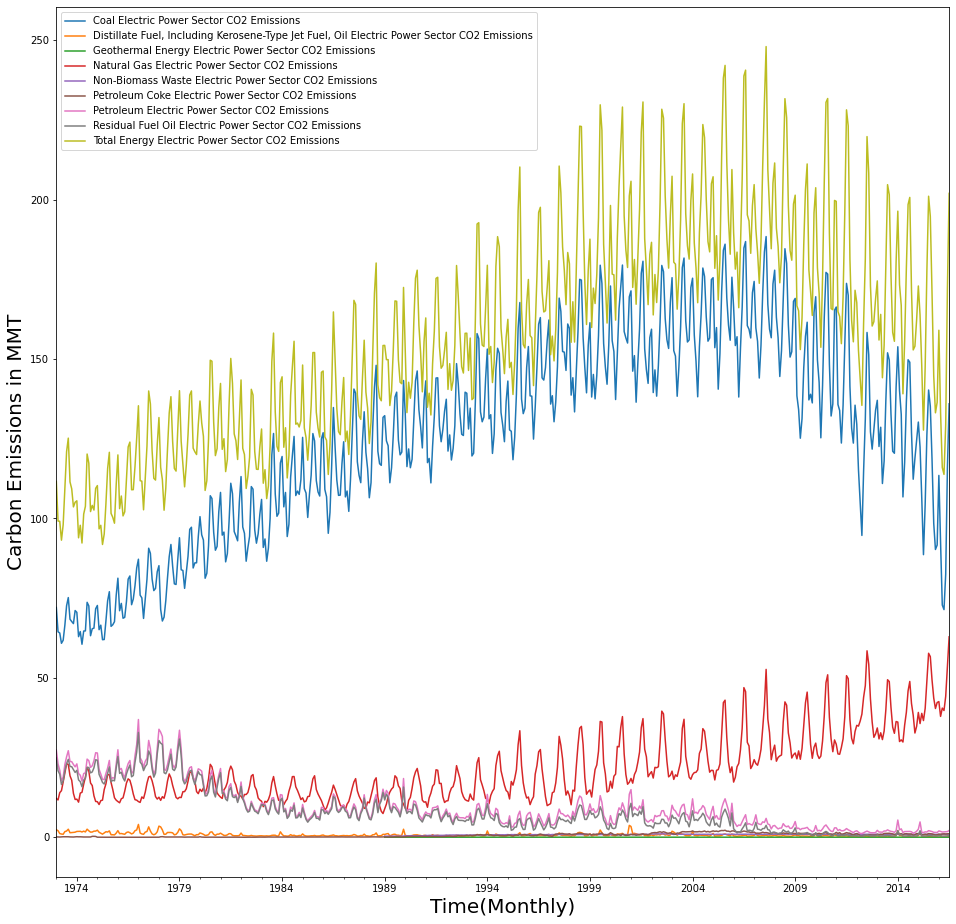

In [63]:
fig, ax = plt.subplots(figsize=(16,16))
#ts.groupby('Description').plot(y='Value',ax=ax,label=desc)

#for label, df in p_df.groupby('class'):
for desc, group in Energy_sources:
    group.Value.plot( ax=ax, label=desc)
    ax.set_xlabel('Time(Monthly)')
    ax.set_ylabel('Carbon Emissions in MMT')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.legend(fontsize = 16)
plt.legend()

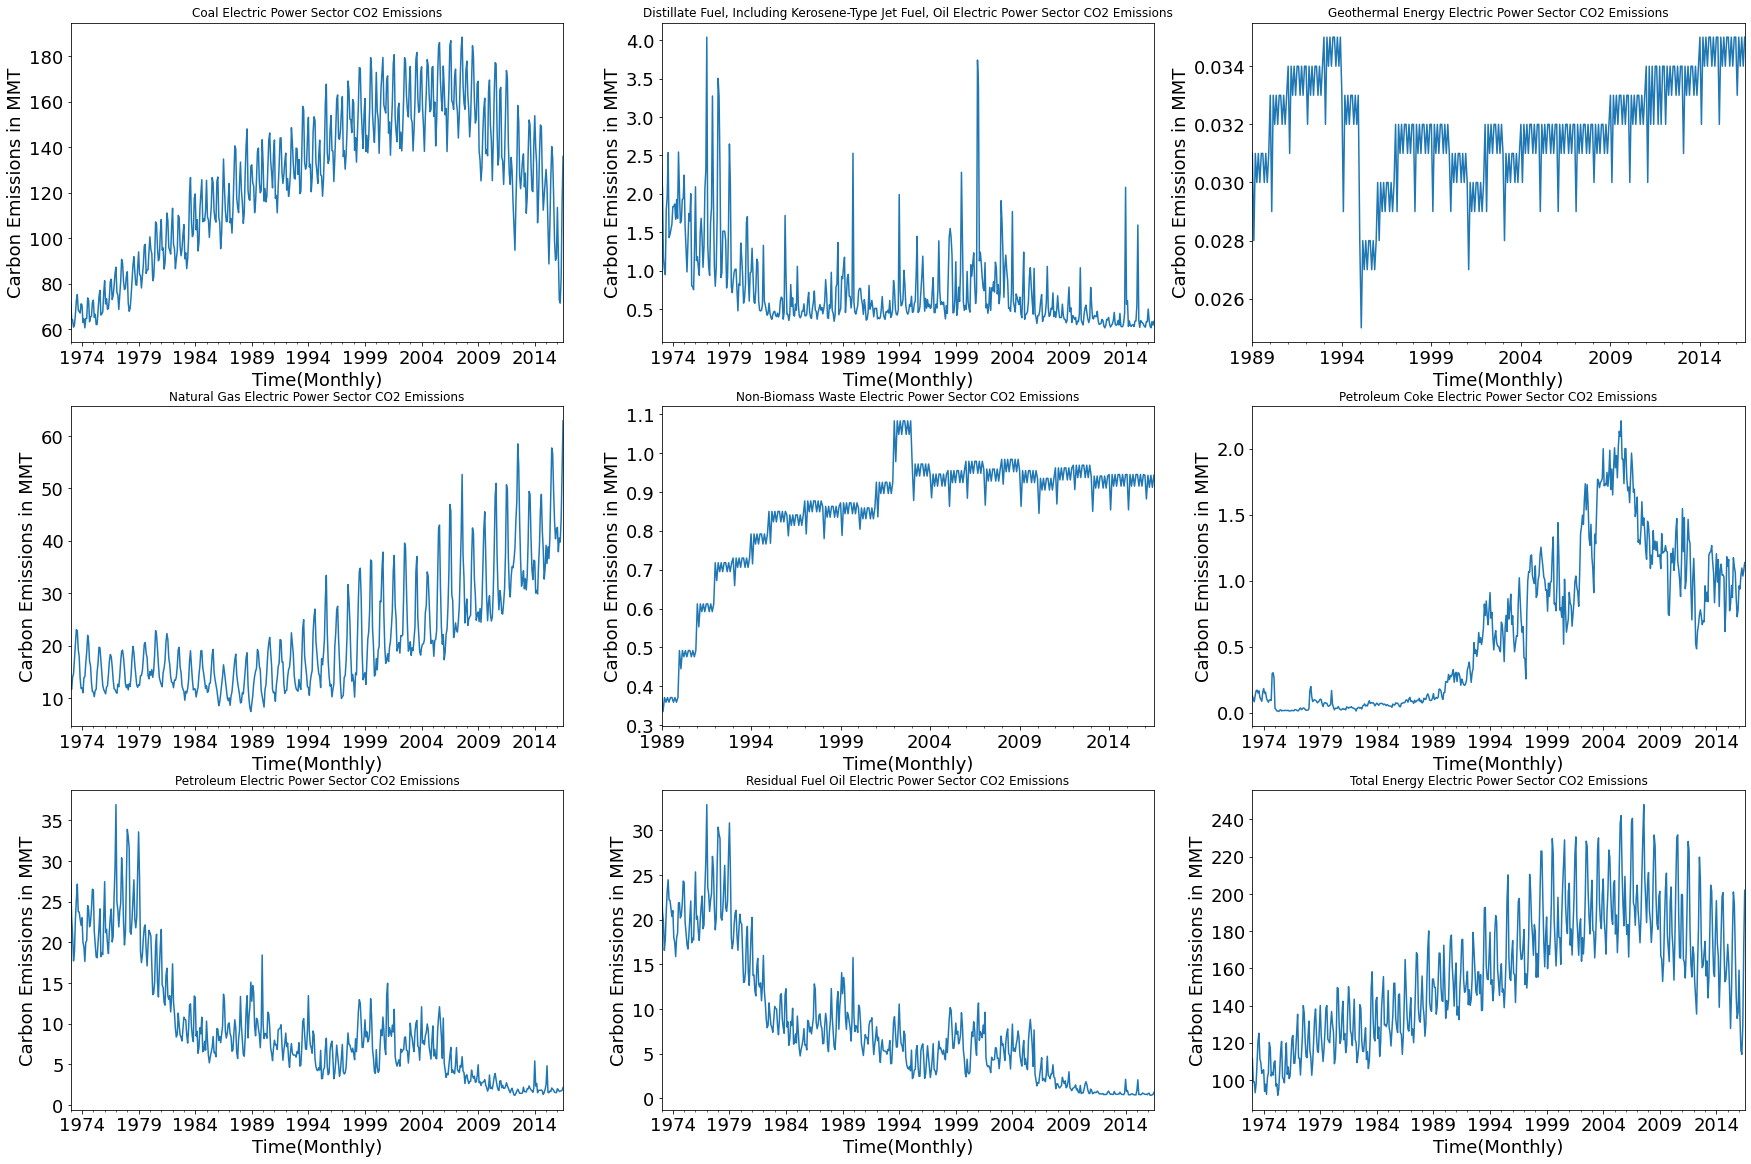

In [64]:
fig, axes = plt.subplots(3,3, figsize = (30, 20))
for (desc, group), ax in zip(Energy_sources, axes.flatten()):
    group.Value.plot(ax = ax, title=desc, fontsize = 18)
    ax.set_xlabel('Time(Monthly)')
    ax.set_ylabel('Carbon Emissions in MMT')
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

In [65]:
CO2_per_source = ts.groupby('Description')['Value'].sum().sort_values()

In [66]:
# I want to use shorter descriptions for the energy sources
CO2_per_source.index

Index(['Geothermal Energy Electric Power Sector CO2 Emissions',
       'Non-Biomass Waste Electric Power Sector CO2 Emissions',
       'Petroleum Coke Electric Power Sector CO2 Emissions',
       'Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions',
       'Residual Fuel Oil Electric Power Sector CO2 Emissions',
       'Petroleum Electric Power Sector CO2 Emissions',
       'Natural Gas Electric Power Sector CO2 Emissions',
       'Coal Electric Power Sector CO2 Emissions',
       'Total Energy Electric Power Sector CO2 Emissions'],
      dtype='object', name='Description')

In [67]:
cols = ['Geothermal Energy', 'Non-Biomass Waste', 'Petroleum Coke','Distillate Fuel ',
        'Residual Fuel Oil', 'Petroleum', 'Natural Gas', 'Coal', 'Total Emissions']

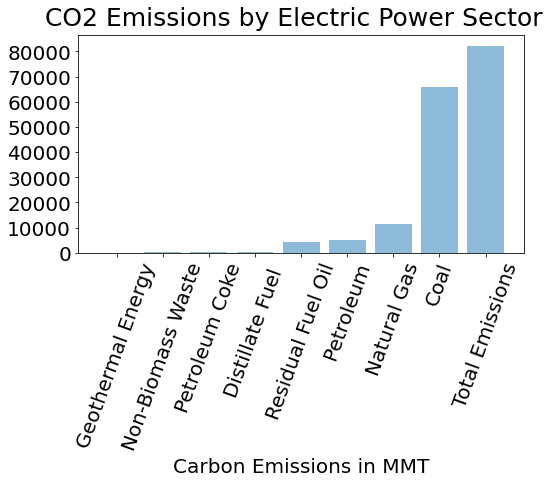

In [68]:
fig = plt.figure(figsize = (8,4))
x_label = cols
x_tick = np.arange(len(cols))
plt.bar(x_tick, CO2_per_source, align = 'center', alpha = 0.5)
fig.suptitle("CO2 Emissions by Electric Power Sector", fontsize= 25)
plt.xticks(x_tick, x_label, rotation = 70, fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Carbon Emissions in MMT', fontsize = 20)
plt.show()

In [69]:
Emissions = ts.iloc[:,1:] # Monthly total emissions (mte)
Emissions= Emissions.groupby(['Description', pd.Grouper(freq='M')])['Value'].sum().unstack(level = 0)
mte = Emissions['Natural Gas Electric Power Sector CO2 Emissions'] # monthly total emissions (mte)
mte.head()

YYYYMM
1973-01-31    12.175
1973-02-28    11.708
1973-03-31    13.994
1973-04-30    14.627
1973-05-31    17.344
Freq: M, Name: Natural Gas Electric Power Sector CO2 Emissions, dtype: float64

In [82]:
from scipy import stats


co2_box, lmbda = stats.boxcox(mte, autolag = 'AIC')
#dta['co2_box'] = np.log(dta.co2)
#fig = plt.figure(figsize(15,3))
plt.plot(co2_box)
#plt.ylabel(u'Transformed CO2')
plt.show()

res_box = sm.tsa.seasonal_decompose(co2_box)

print("The Augmented Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(co2_box)[1])

#fig = plt.figure(figsize=(12,8))
res_box.plot()
plt.show()

print("Optimal parameter for the Box-Cox transformation: %f" % lmbda)
print("The Augmented Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(dta.co2_box)[1])

TypeError: boxcox() got an unexpected keyword argument 'autolag'

# Test Stationarity

In [18]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

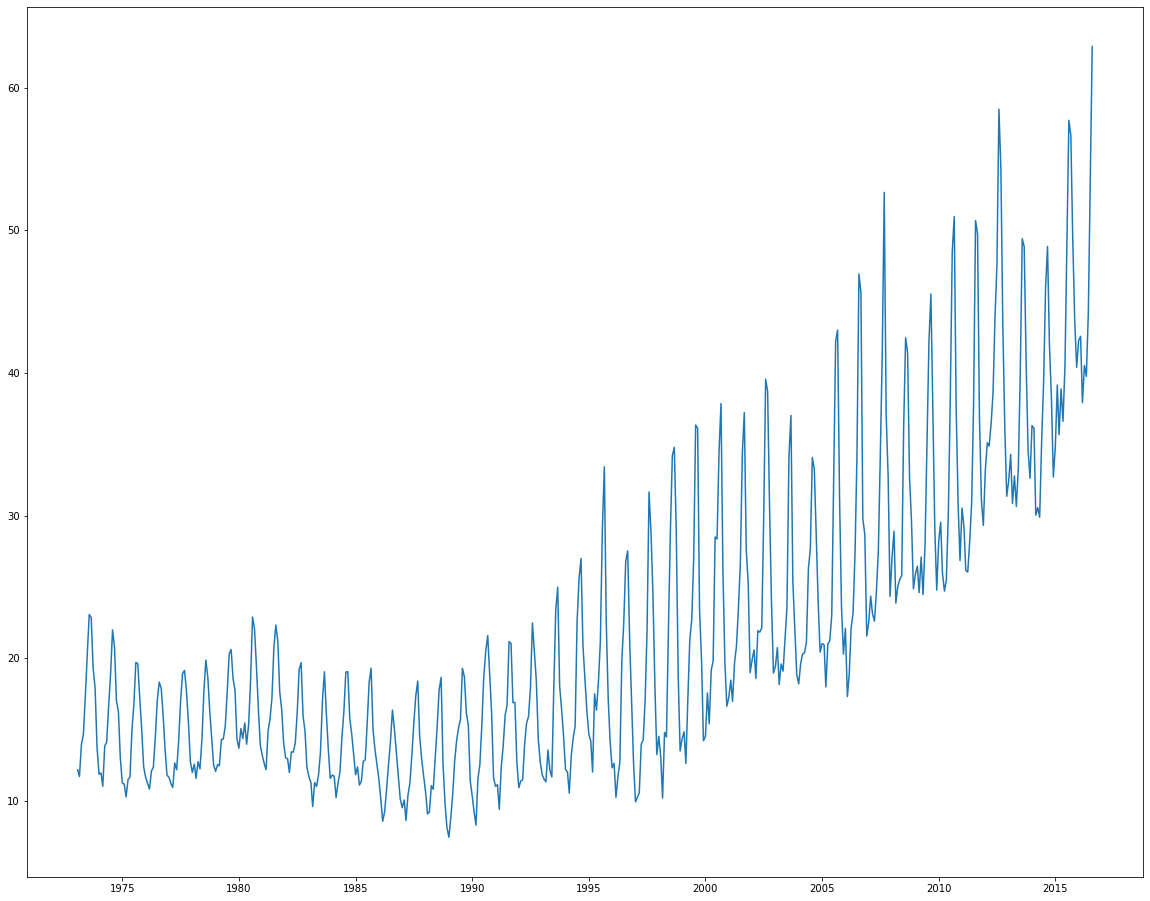

In [19]:
plt.plot(mte)
plt.show()

In [20]:
def TestStationaryPlot(ts, plot_label = None):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    
    plt.xlabel('Time in Years', fontsize = 25)
    plt.ylabel('Total Emissions', fontsize = 25)
    plt.legend(loc='best', fontsize = 25)
    if plot_label is not None:
        plt.title('Rolling Mean & Standard Deviation (' + plot_label + ')', fontsize = 25)
    else:
        plt.title('Rolling Mean & Standard Deviation', fontsize = 25)
    plt.show(block= True)

In [21]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        

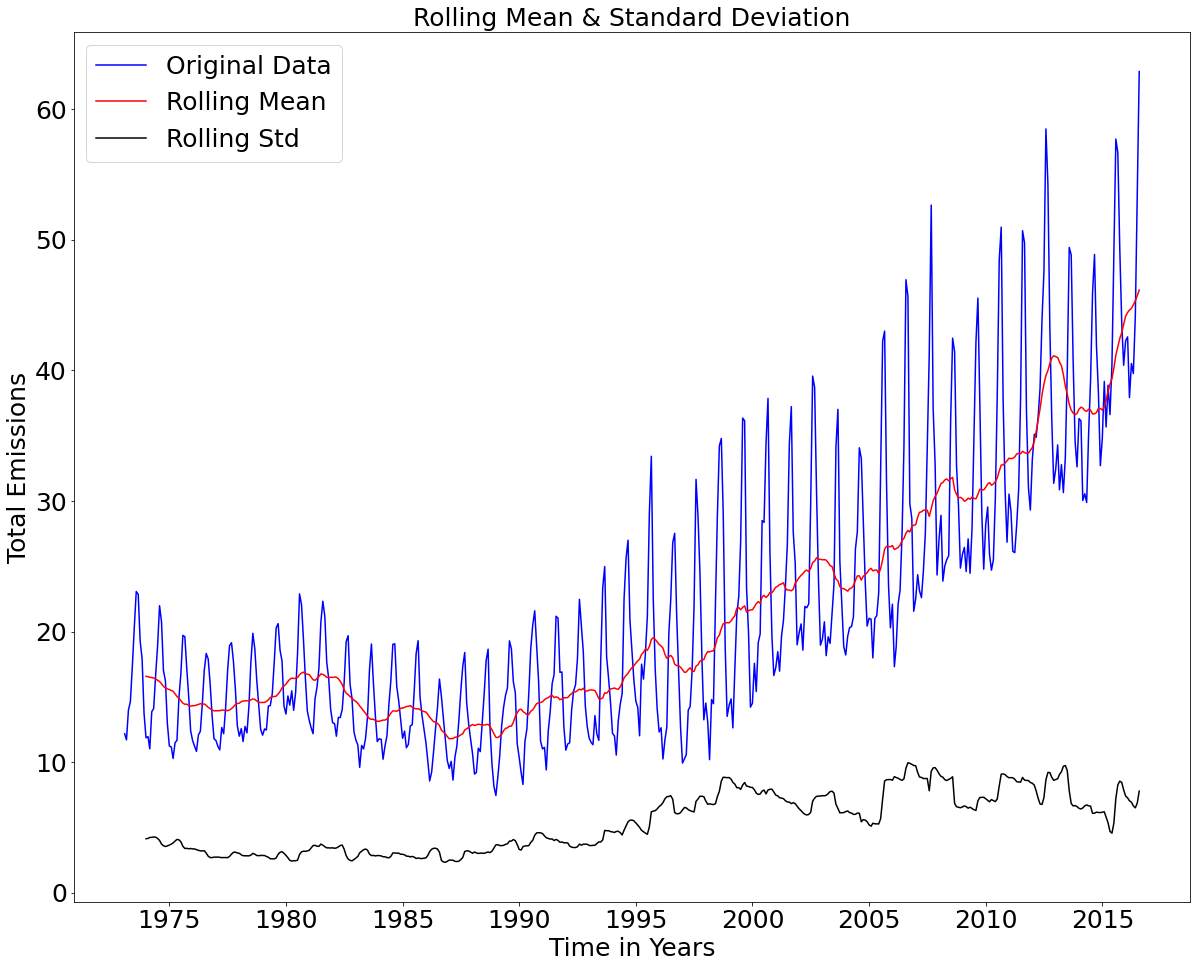

In [22]:
TestStationaryPlot(mte)

In [86]:
TestStationaryAdfuller(mte)

Test Statistic                   1.831215
p-value                          0.998409
#Lags Used                      19.000000
Number of Observations Used    503.000000
Critical Value (1%)             -3.443418
Critical Value (5%)             -2.867303
Critical Value (10%)            -2.569840
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


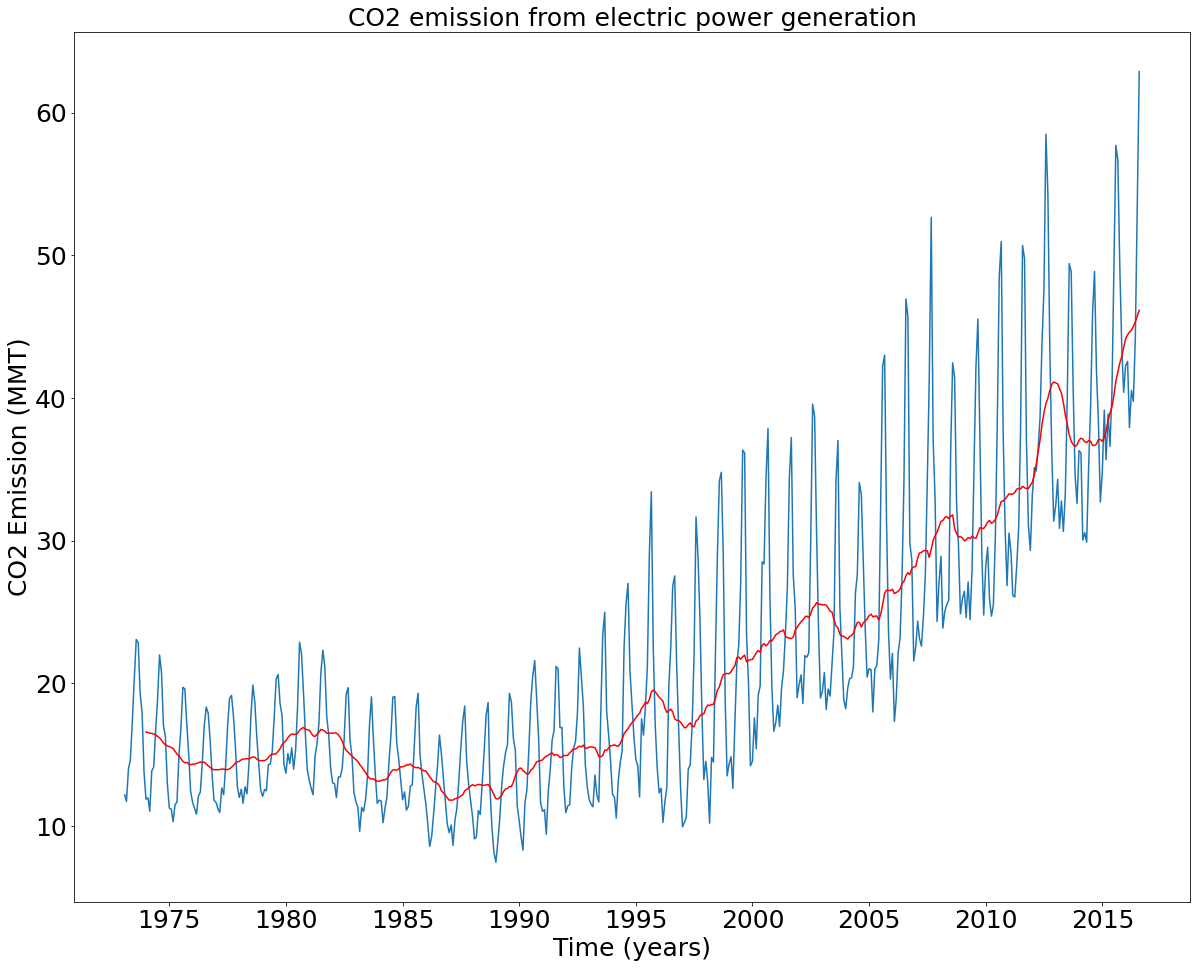

In [24]:
moving_avg = mte.rolling(12).mean()
plt.plot(mte)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Time (years)', fontsize = 25)
plt.ylabel('CO2 Emission (MMT)', fontsize = 25)
plt.title('CO2 emission from electric power generation', fontsize = 25)
plt.show()

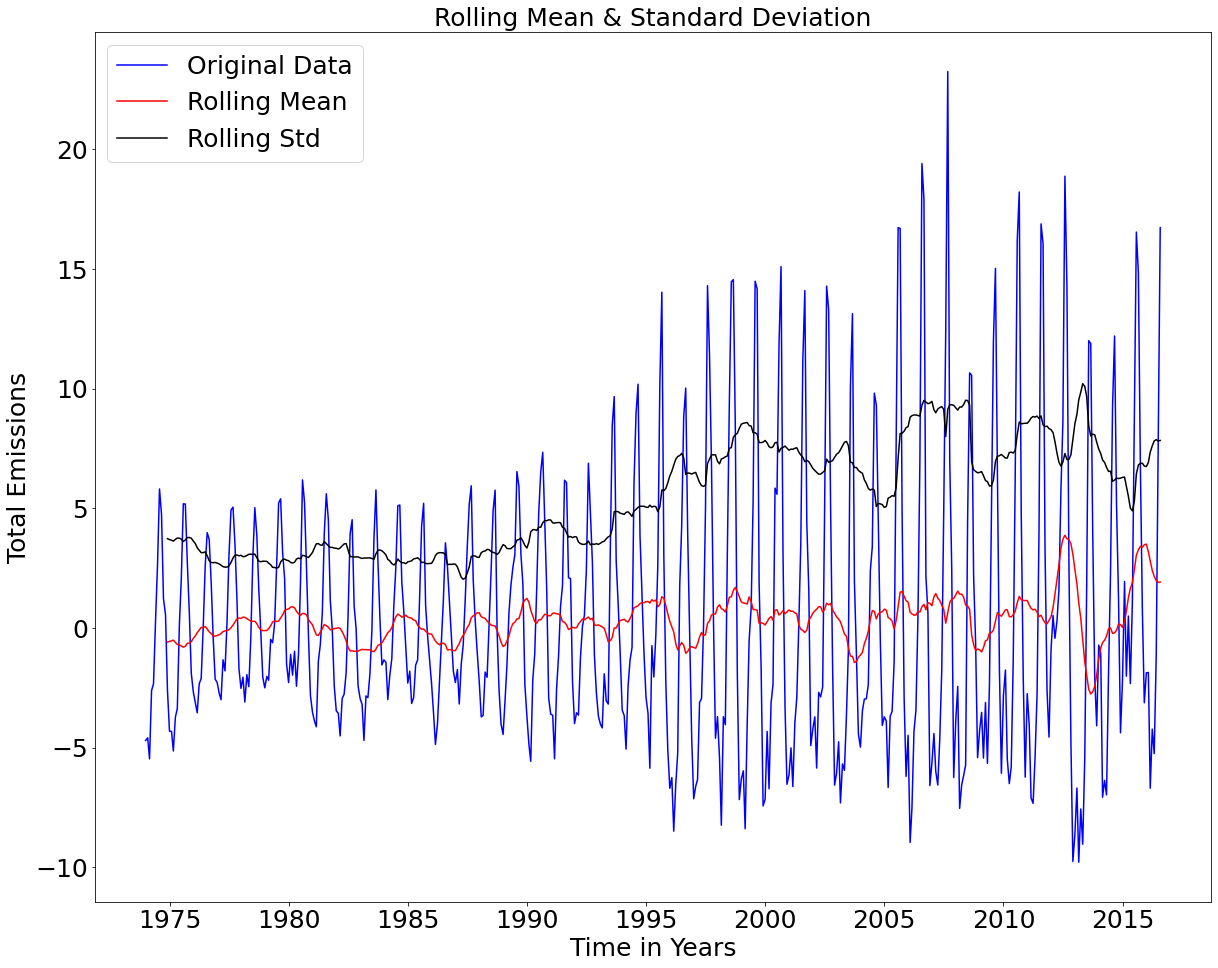

In [25]:
mte_moving_avg_diff = mte - moving_avg
mte_moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(mte_moving_avg_diff)

In [26]:
TestStationaryAdfuller(mte_moving_avg_diff)

Test Statistic                  -5.138977
p-value                          0.000012
#Lags Used                      19.000000
Number of Observations Used    492.000000
Critical Value (1%)             -3.443711
Critical Value (5%)             -2.867432
Critical Value (10%)            -2.569908
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


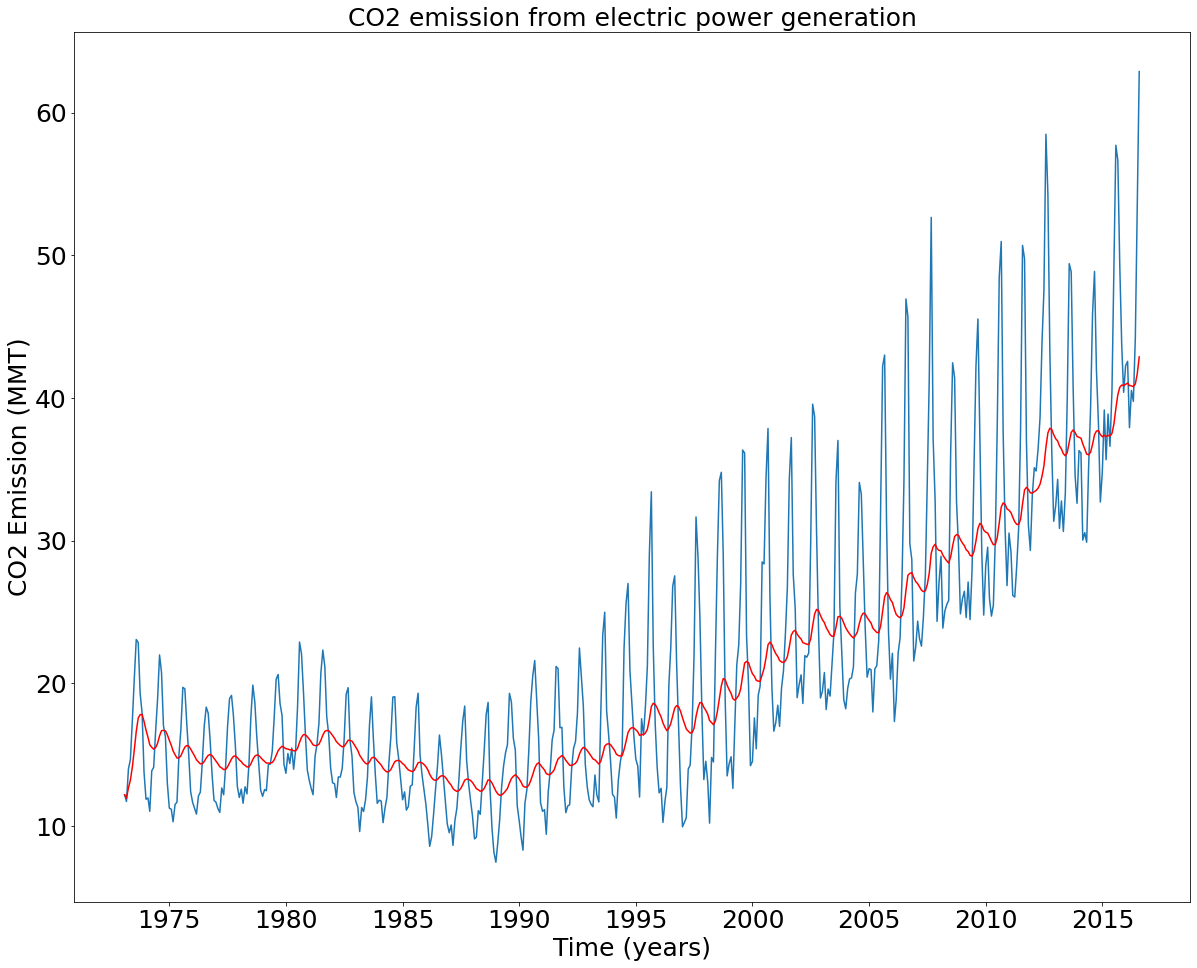

In [27]:
mte_exp_weighted_avg = mte.ewm(halflife=12).mean()
plt.plot(mte)
plt.plot(mte_exp_weighted_avg, color='red')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Time (years)', fontsize = 25)
plt.ylabel('CO2 Emission (MMT)', fontsize = 25)
plt.title('CO2 emission from electric power generation', fontsize = 25)
plt.show()

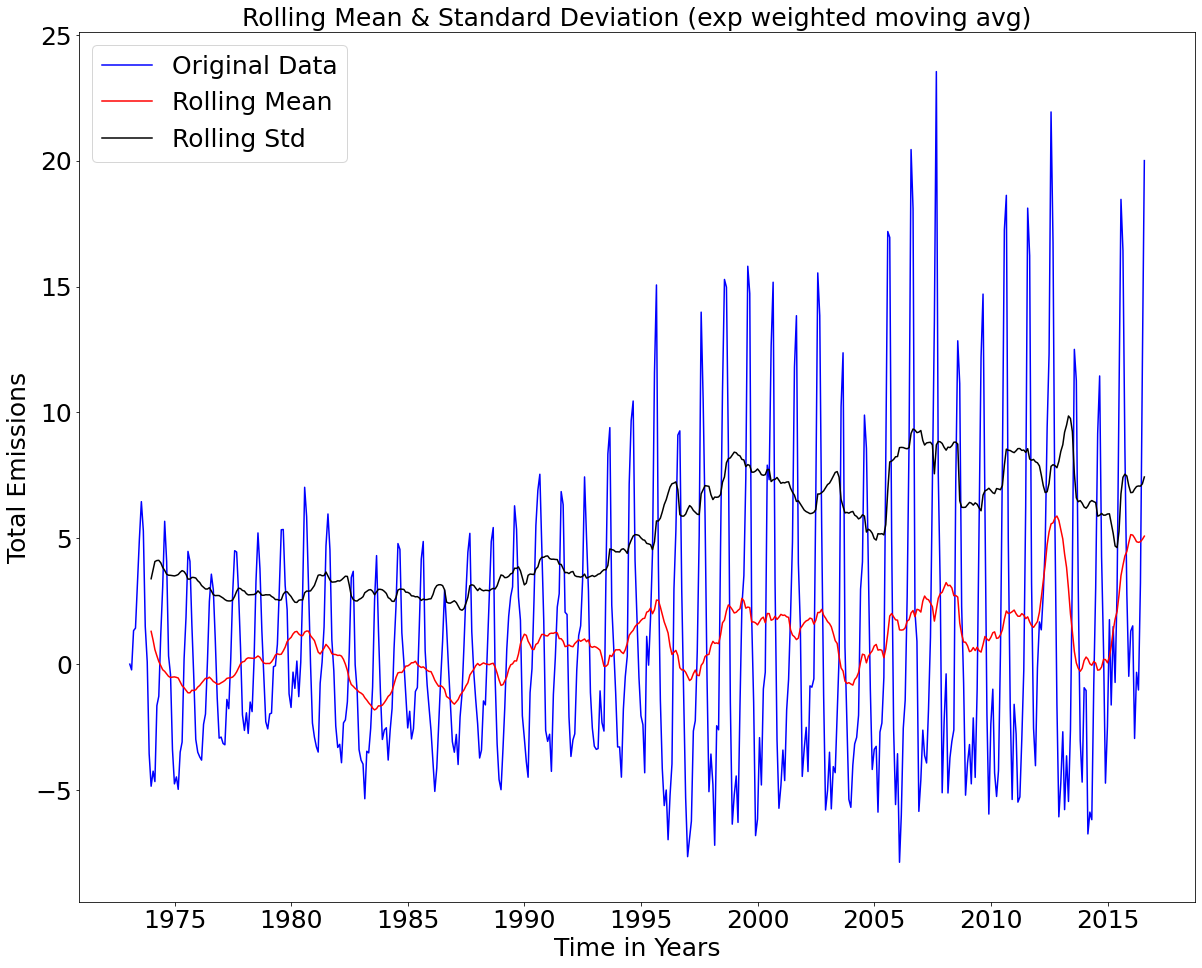

In [28]:
mte_ewma_diff = mte - mte_exp_weighted_avg
TestStationaryPlot(mte_ewma_diff, 'exp weighted moving avg')

In [29]:
TestStationaryAdfuller(mte_ewma_diff)

Test Statistic                  -3.423915
p-value                          0.010170
#Lags Used                      19.000000
Number of Observations Used    503.000000
Critical Value (1%)             -3.443418
Critical Value (5%)             -2.867303
Critical Value (10%)            -2.569840
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


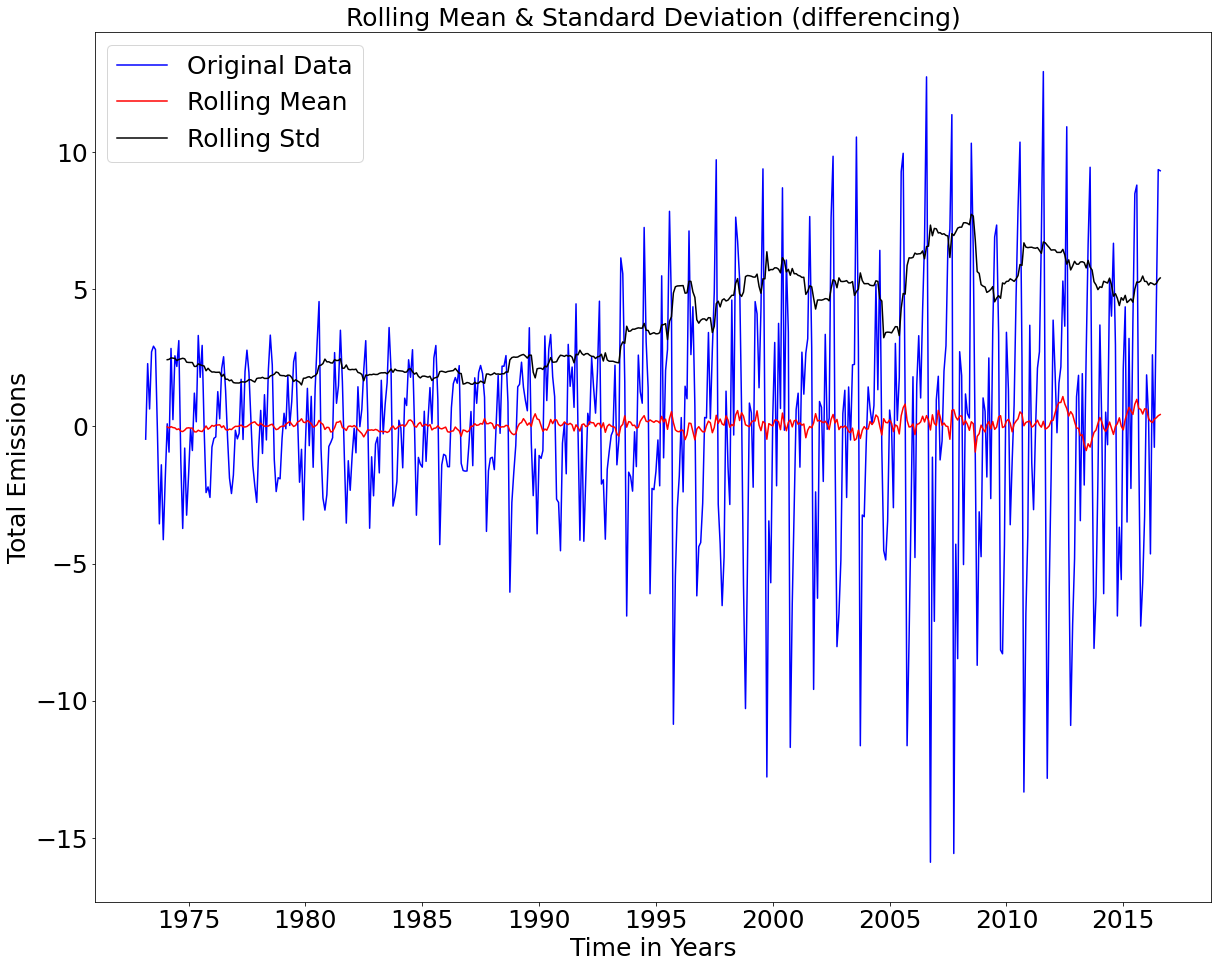

In [30]:
mte_first_difference = mte - mte.shift(1)  
TestStationaryPlot(mte_first_difference.dropna(inplace=False), 'differencing')

In [31]:
TestStationaryAdfuller(mte_first_difference.dropna(inplace=False))

Test Statistic                  -5.435116
p-value                          0.000003
#Lags Used                      18.000000
Number of Observations Used    503.000000
Critical Value (1%)             -3.443418
Critical Value (5%)             -2.867303
Critical Value (10%)            -2.569840
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


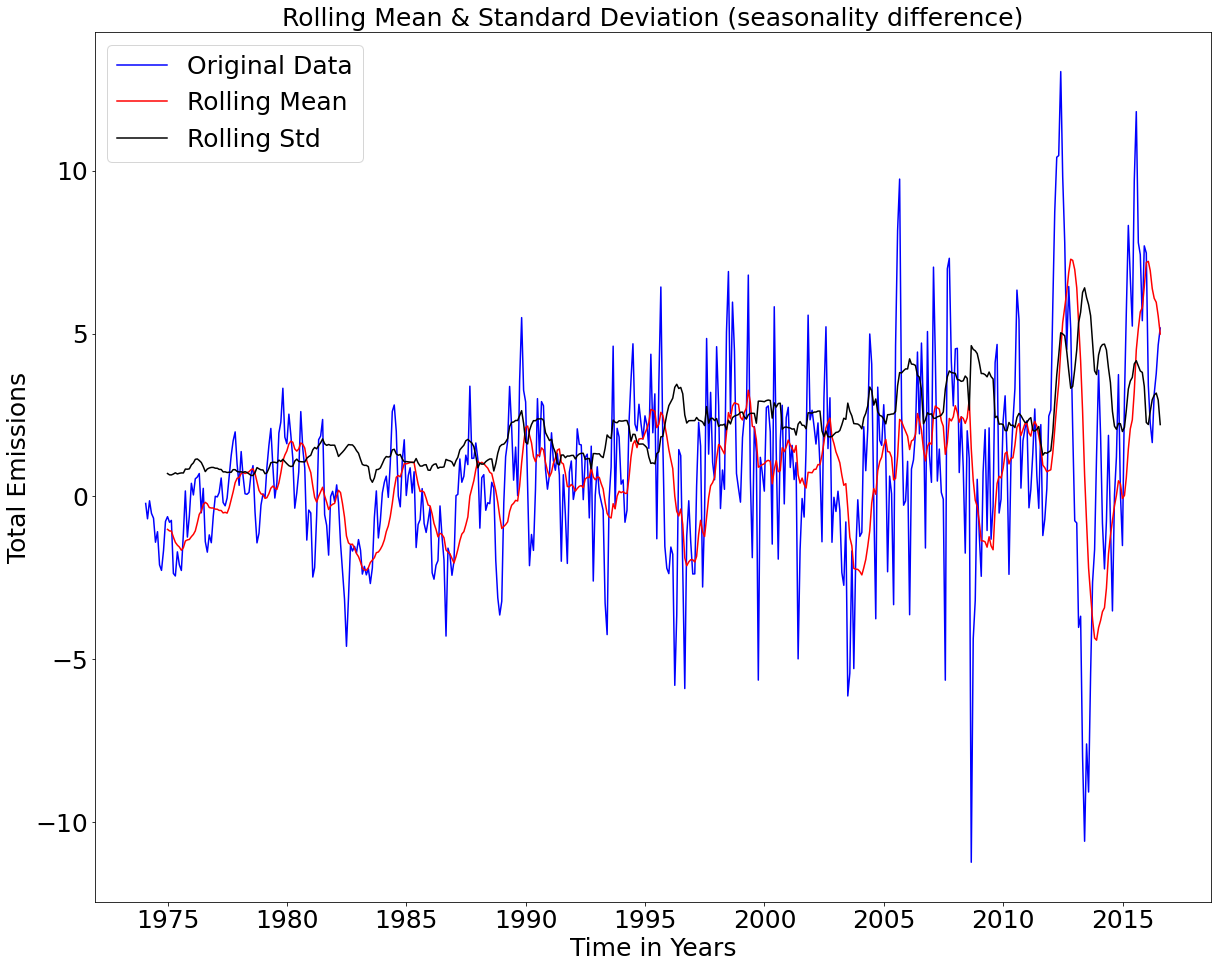

Test Statistic                  -4.412396
p-value                          0.000282
#Lags Used                      13.000000
Number of Observations Used    497.000000
Critical Value (1%)             -3.443576
Critical Value (5%)             -2.867373
Critical Value (10%)            -2.569877
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [32]:
mte_seasonal_difference = mte - mte.shift(12)  
TestStationaryPlot(mte_seasonal_difference.dropna(inplace=False), 'seasonality difference')
TestStationaryAdfuller(mte_seasonal_difference.dropna(inplace=False))

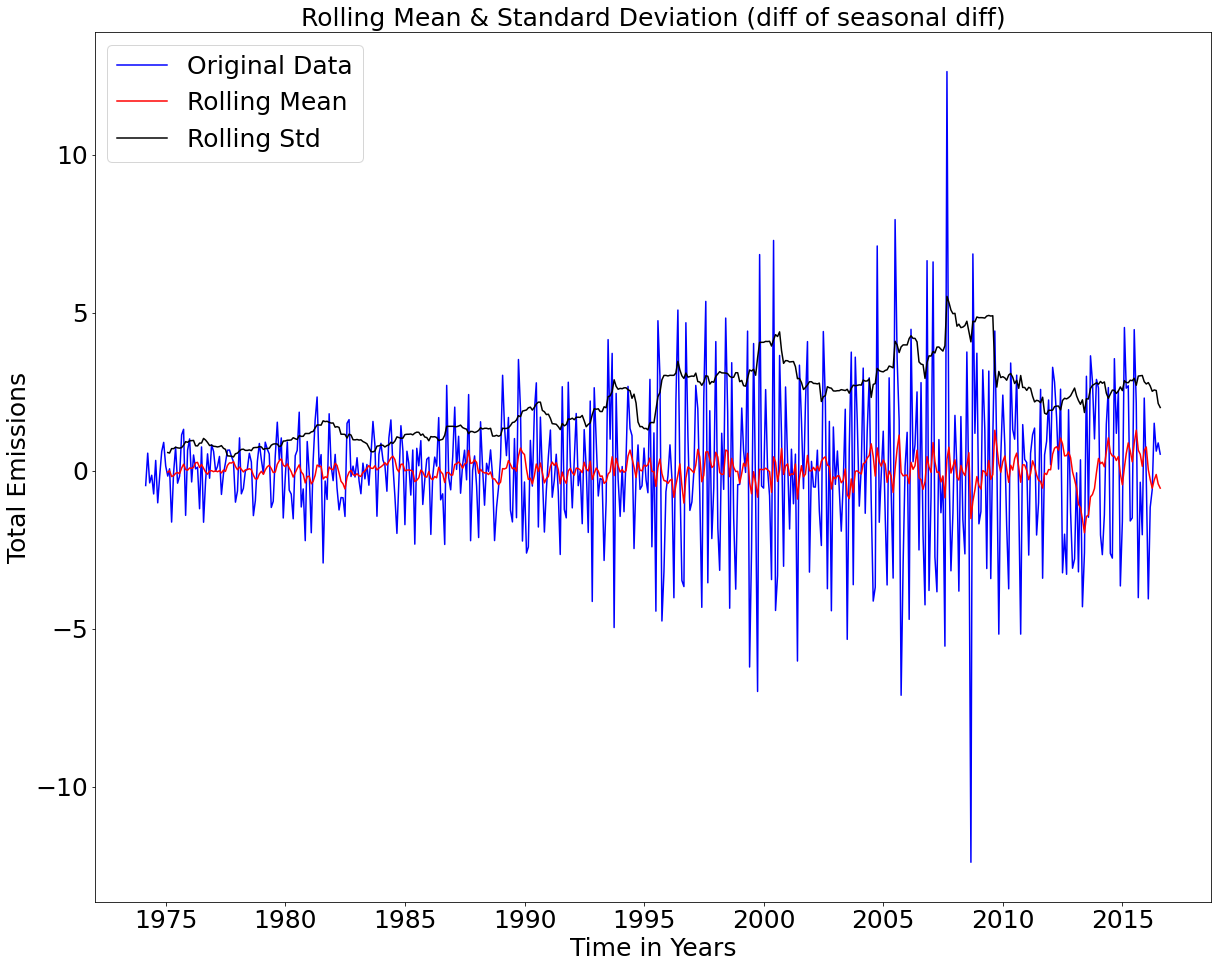

In [33]:
mte_seasonal_first_difference = mte_first_difference - mte_first_difference.shift(12)  
TestStationaryPlot(mte_seasonal_first_difference.dropna(inplace=False), 'diff of seasonal diff')

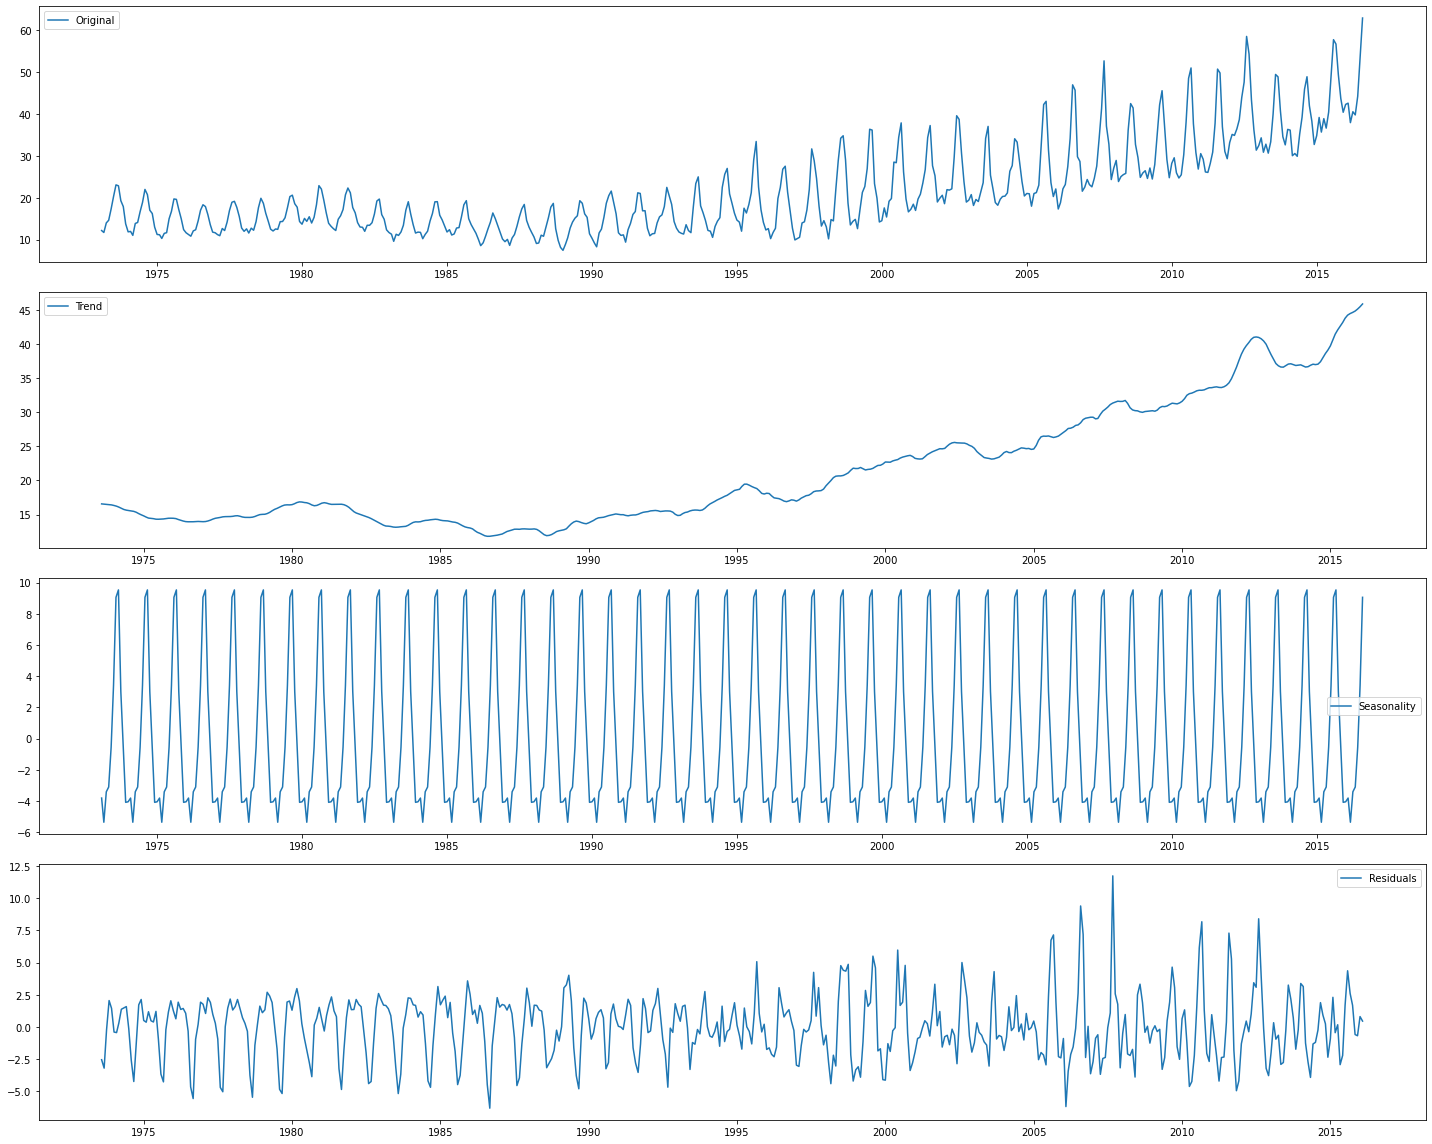

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(mte)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(mte, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

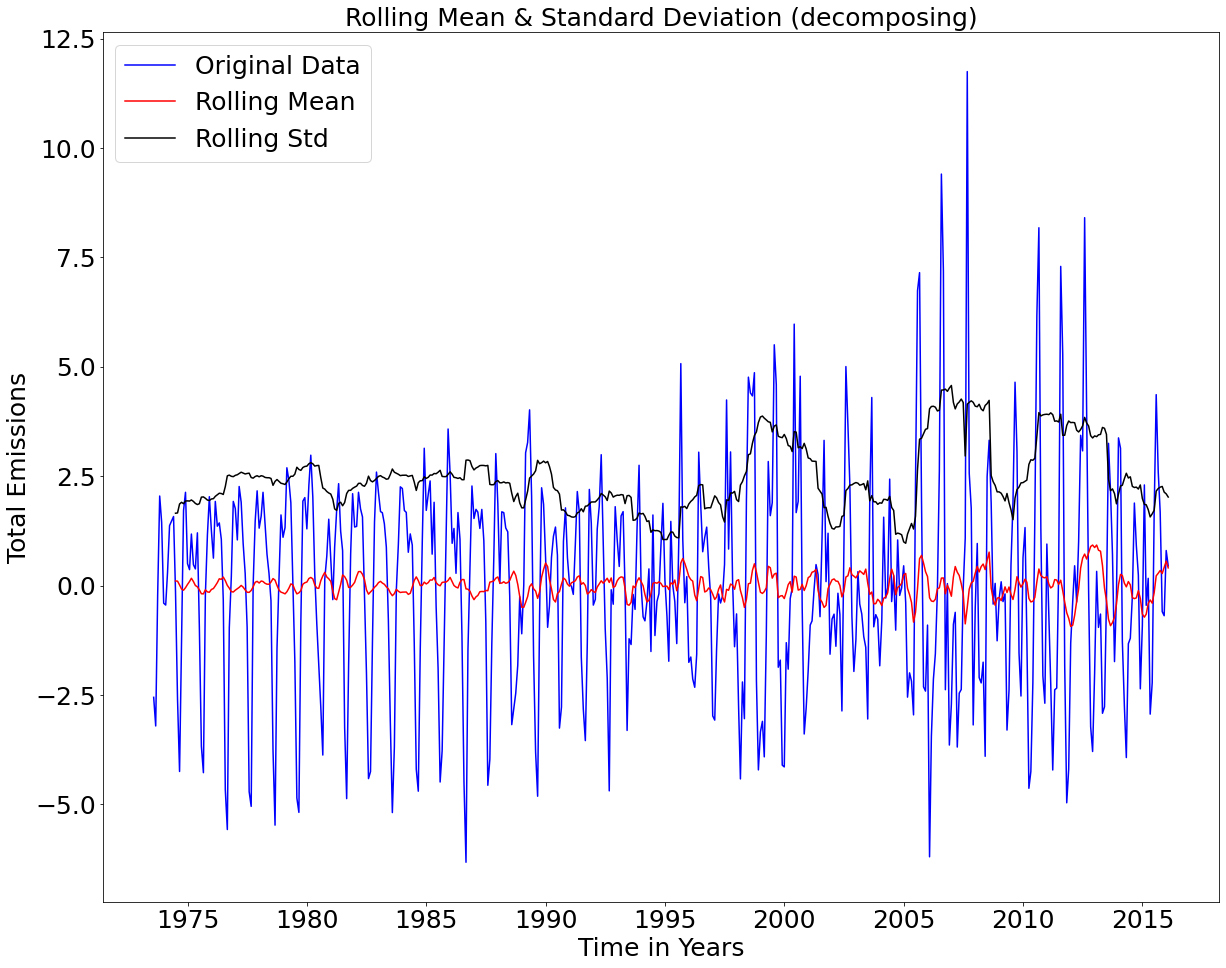

Test Statistic                -8.547084e+00
p-value                        9.439345e-14
#Lags Used                     1.900000e+01
Number of Observations Used    4.910000e+02
Critical Value (1%)           -3.443739e+00
Critical Value (5%)           -2.867444e+00
Critical Value (10%)          -2.569915e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [35]:
mte_decompose = residual
mte_decompose.dropna(inplace=True)
TestStationaryPlot(mte_decompose, 'decomposing')
TestStationaryAdfuller(mte_decompose)

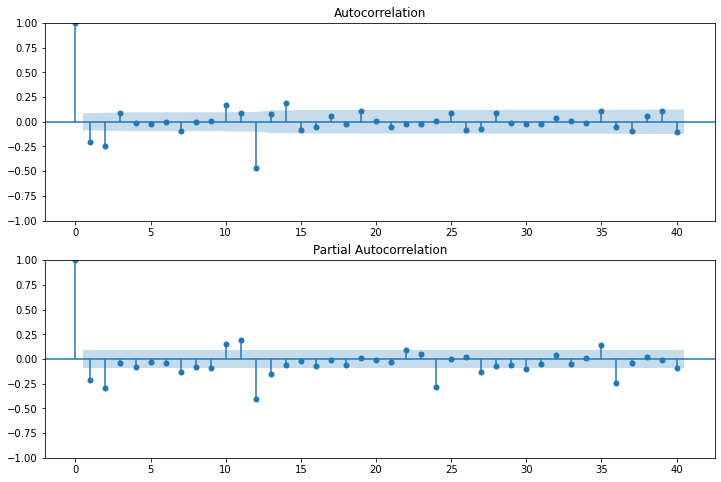

In [36]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [37]:
p = d = q = range(0, 3) # Define the p, d and q parameters to take any value between 0 and 2
P = D = Q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2

pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets

#pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))] # Generate all different combinations of seasonal p, q and q triplets

print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)


In [38]:
aic_results = []
best_param =[]
best_seasonal_param =[]
best_aic = np.inf

for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(mte,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, seasonal_param, results.aic))
            if results.mle_retvals is not None and results.mle_retvals['converged'] == False:
                print(results.mle_retvals)
            aic_results.append(results.aic)
            if results.aic  < best_aic:
                best_aic = results.aic
                best_param = param
                best_seasonal_param = seasonal_param
        except:
            continue
aic_results.sort()
print('Best AIC found: ', aic_results[0])
print('Best model {} {}. AIC:{}'.format(best_param,best_seasonal_param, best_aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:4804.065995091218
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:4135.625648186418
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:2572.194757744371
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2504.2095028358463
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:2544.1464266167964
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:2465.147262996248
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:2511.043139693217
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:2505.8402380709176
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:4157.561225515814
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:3572.1059017868774
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:2334.7247254087943
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:2245.5073864208443
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:2329.0446013810656
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2218.68009776452
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:2262.0627979899255
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:2247.5327721888925
ARIMA(0, 0, 2)x(0, 0, 0, 12) - AIC:3732.6559909252974
ARIMA(0, 0, 2)x(0, 0, 1, 12) - AIC:3351.7397938387207
ARIMA(0, 0, 2)x(0, 1, 0, 12) - AIC:2

In [39]:
mod = sm.tsa.statespace.SARIMAX(mte, 
                                order=best_param, 
                                seasonal_order=best_seasonal_param,   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                              SARIMAX Results                                              
Dep. Variable:     Natural Gas Electric Power Sector CO2 Emissions   No. Observations:                  523
Model:                            SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -996.085
Date:                                             Tue, 12 Oct 2021   AIC                           2002.170
Time:                                                     11:05:19   BIC                           2023.193
Sample:                                                 01-31-1973   HQIC                          2010.423
                                                      - 07-31-2016                                         
Covariance Type:                                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

<AxesSubplot:xlabel='YYYYMM'>

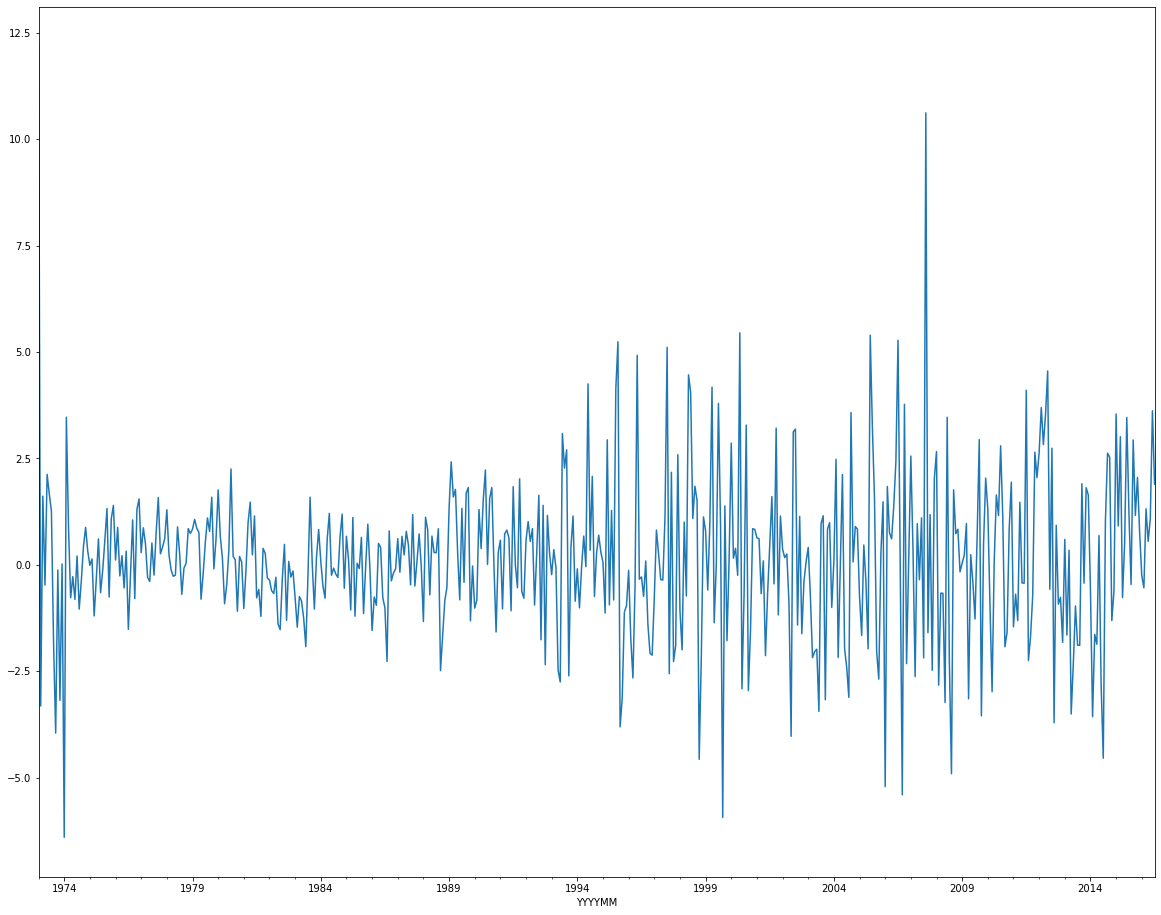

In [40]:
results.resid.plot()

In [41]:
print(results.resid.describe())

count    523.000000
mean       0.147001
std        1.885439
min       -6.402212
25%       -0.790181
50%        0.111565
75%        1.059301
max       12.175000
dtype: float64


<AxesSubplot:ylabel='Density'>

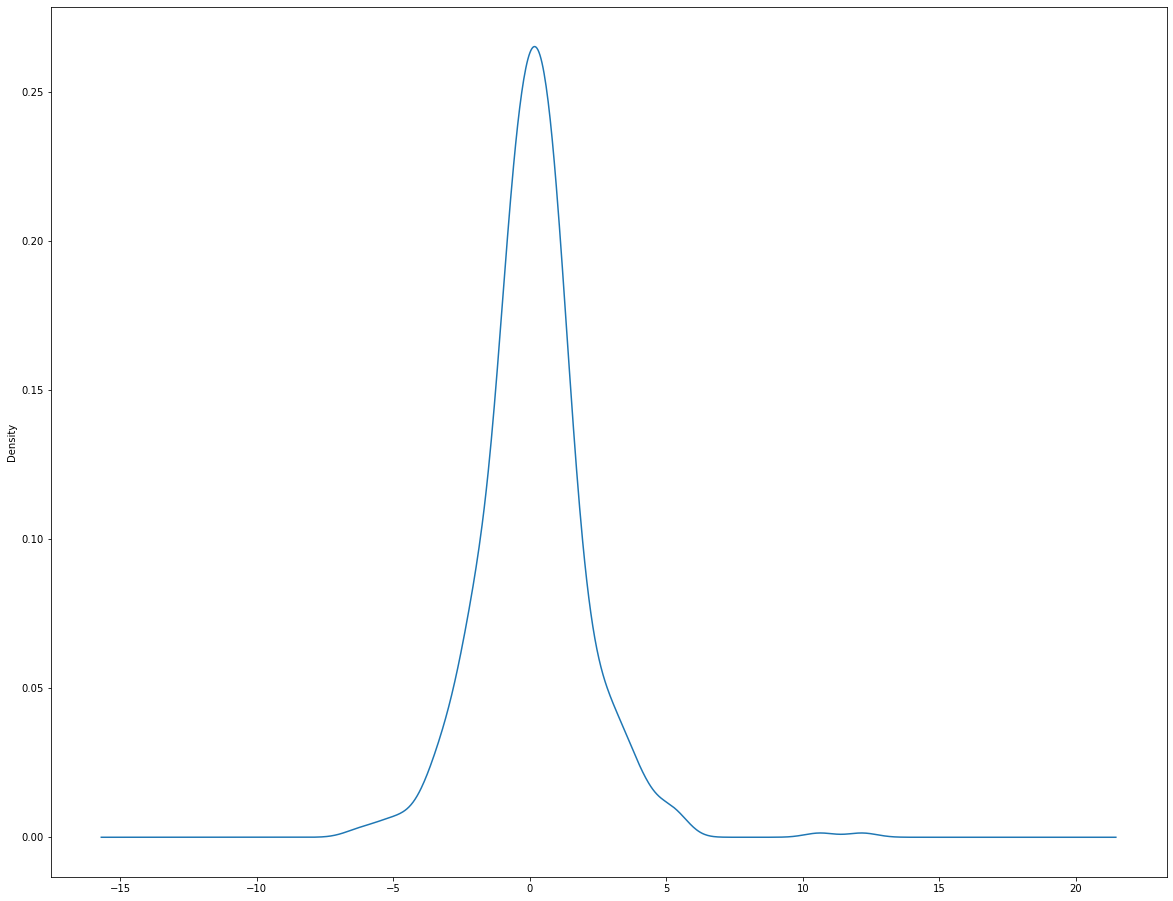

In [42]:
results.resid.plot(kind='kde')

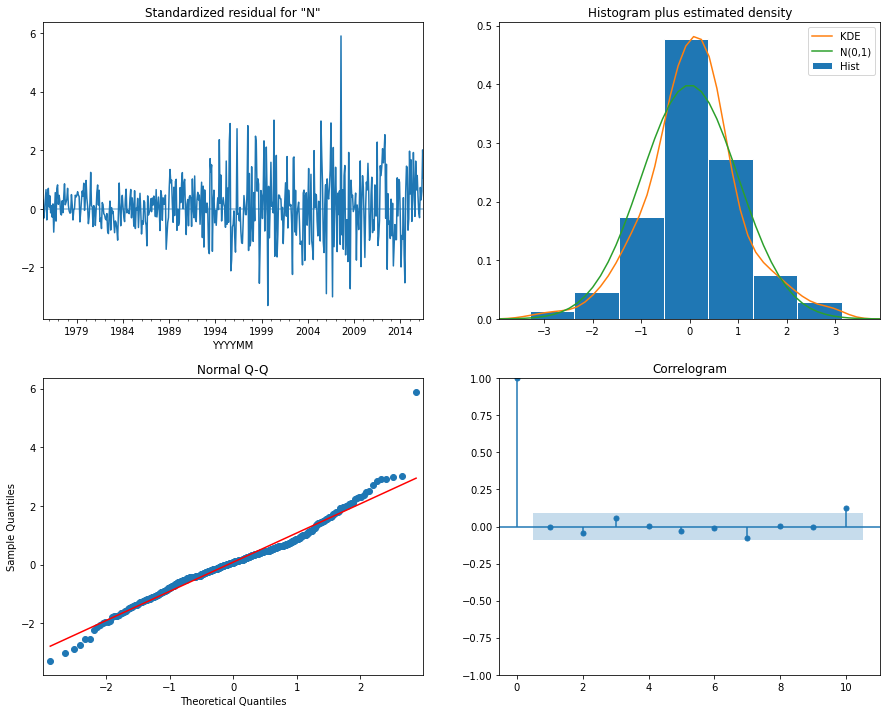

In [43]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [44]:
pred = results.get_prediction(start = 480, end = 522, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

lower Natural Gas Electric Power Sector CO2 Emissions  \
YYYYMM                                                              
2013-01-31                                          30.168973       
2013-02-28                                          28.979055       
2013-03-31                                          28.908159       
2013-04-30                                          30.617842       
2013-05-31                                          32.117033       

            upper Natural Gas Electric Power Sector CO2 Emissions  
YYYYMM                                                             
2013-01-31                                          37.226670      
2013-02-28                                          36.036752      
2013-03-31                                          35.965856      
2013-04-30                                          37.675539      
2013-05-31                                          39.174731

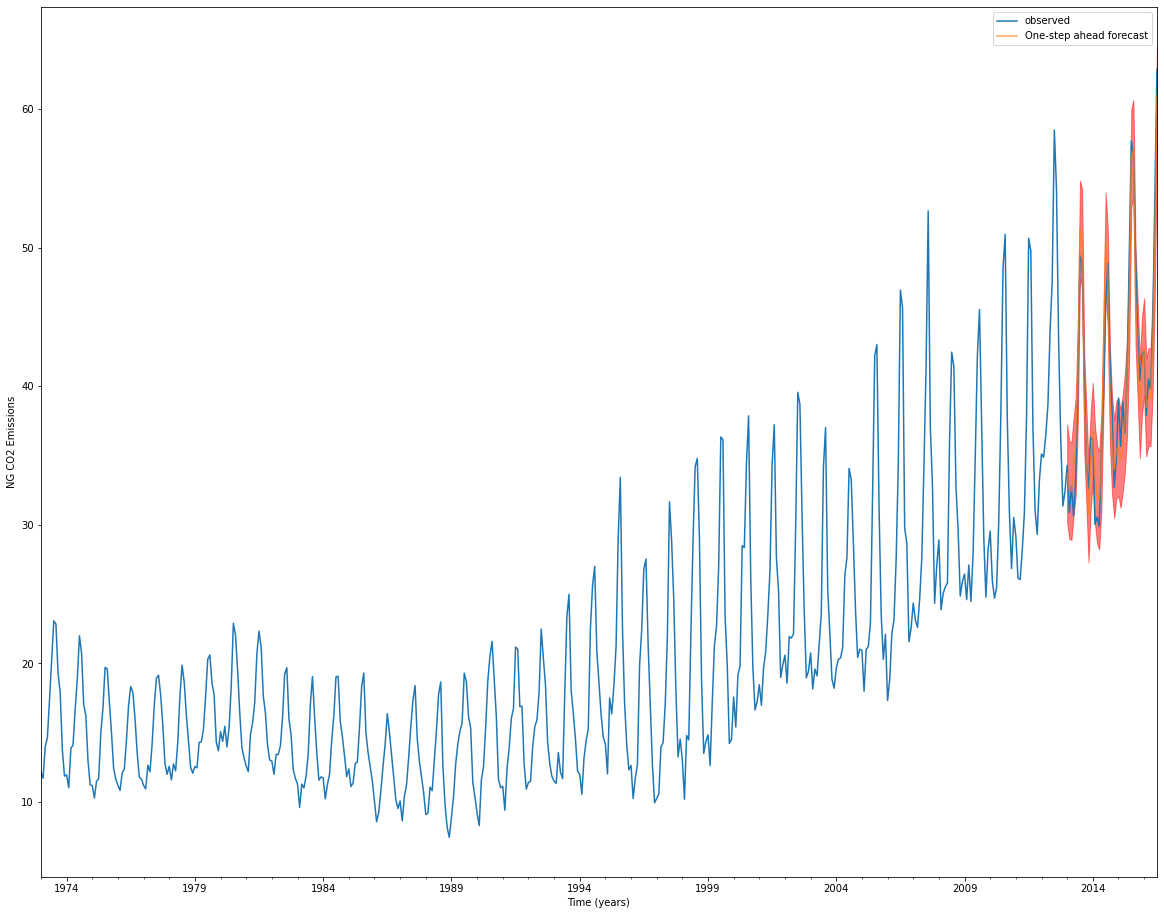

In [45]:
ax = mte['1973':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Time (years)')
ax.set_ylabel('NG CO2 Emissions')
plt.legend()

plt.show()

In [46]:
mte_forecast = pred.predicted_mean
mte_truth = mte['2013-01-31':]

# Compute the mean square error
mse = ((mte_forecast - mte_truth) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forecast: {:.4f}'
      .format(np.sqrt(sum((mte_forecast-mte_truth)**2)/len(mte_forecast))))

The Mean Squared Error (MSE) of the forecast is 4.08
The Root Mean Square Error (RMSE) of the forecast: 2.0197


In [47]:
mte_pred_concat = pd.concat([mte_truth, mte_forecast])

In [49]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2013-01-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

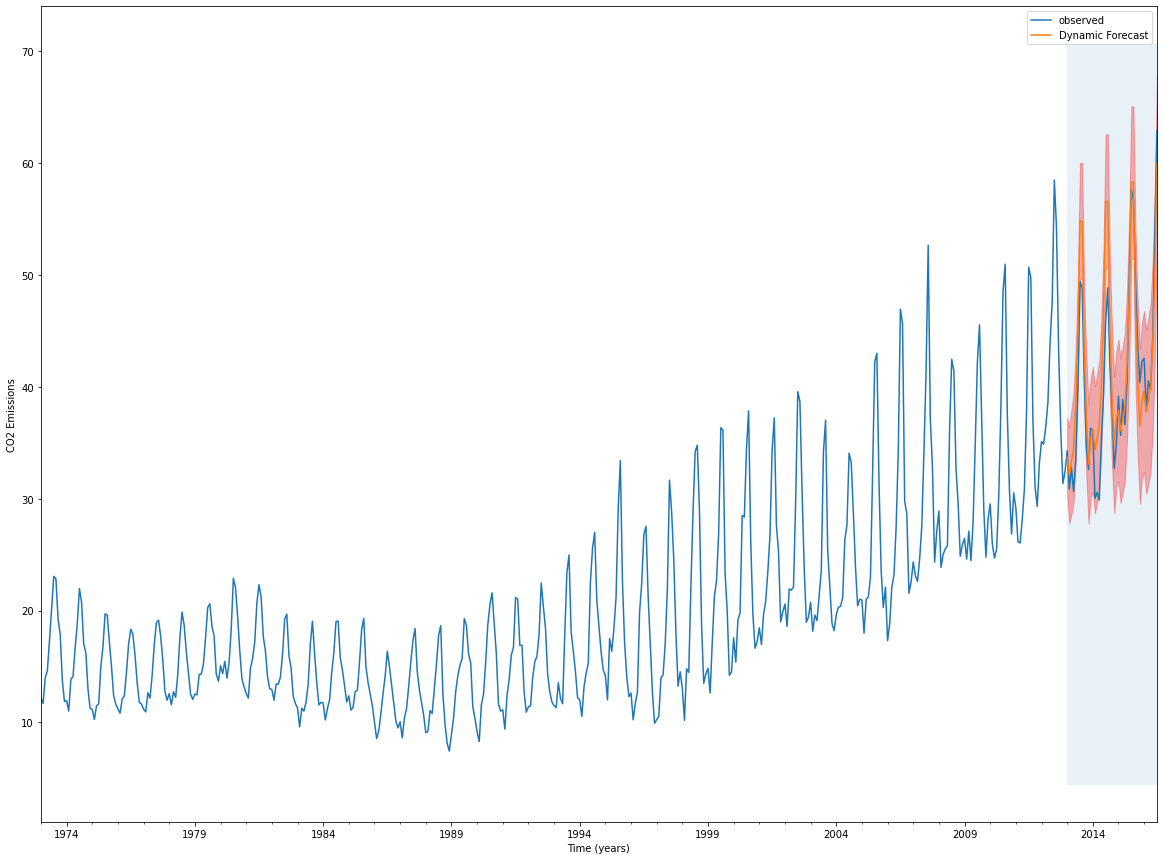

In [50]:
ax = mte['1973':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], 
                color='r', 
                alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-01-31'), 
                 mte.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('CO2 Emissions')

plt.legend()
plt.show()

In [51]:
# Extract the predicted and true values of our time series
mte_forecast = pred_dynamic.predicted_mean
mte_original = mte['2013-01-31':]

# Compute the mean square error
mse = ((mte_forecast - mte_original) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forecast: {:.4f}'
      .format(np.sqrt(sum((mte_forecast-mte_original)**2)/len(mte_forecast))))

The Mean Squared Error (MSE) of the forecast is 13.81
The Root Mean Square Error (RMSE) of the forecast: 3.7161


In [52]:
# Get forecast of 10 years or 120 months steps ahead in future
forecast = results.get_forecast(steps= 120)
# Get confidence intervals of forecasts
forecast_ci = forecast.conf_int()
forecast_ci.head()

lower Natural Gas Electric Power Sector CO2 Emissions  \
2016-08-31                                          58.052681       
2016-09-30                                          47.416517       
2016-10-31                                          40.822806       
2016-11-30                                          36.227831       
2016-12-31                                          38.102749       

            upper Natural Gas Electric Power Sector CO2 Emissions  
2016-08-31                                          65.110379      
2016-09-30                                          56.012129      
2016-10-31                                          50.188894      
2016-11-30                                          46.028619      
2016-12-31                                          48.169977

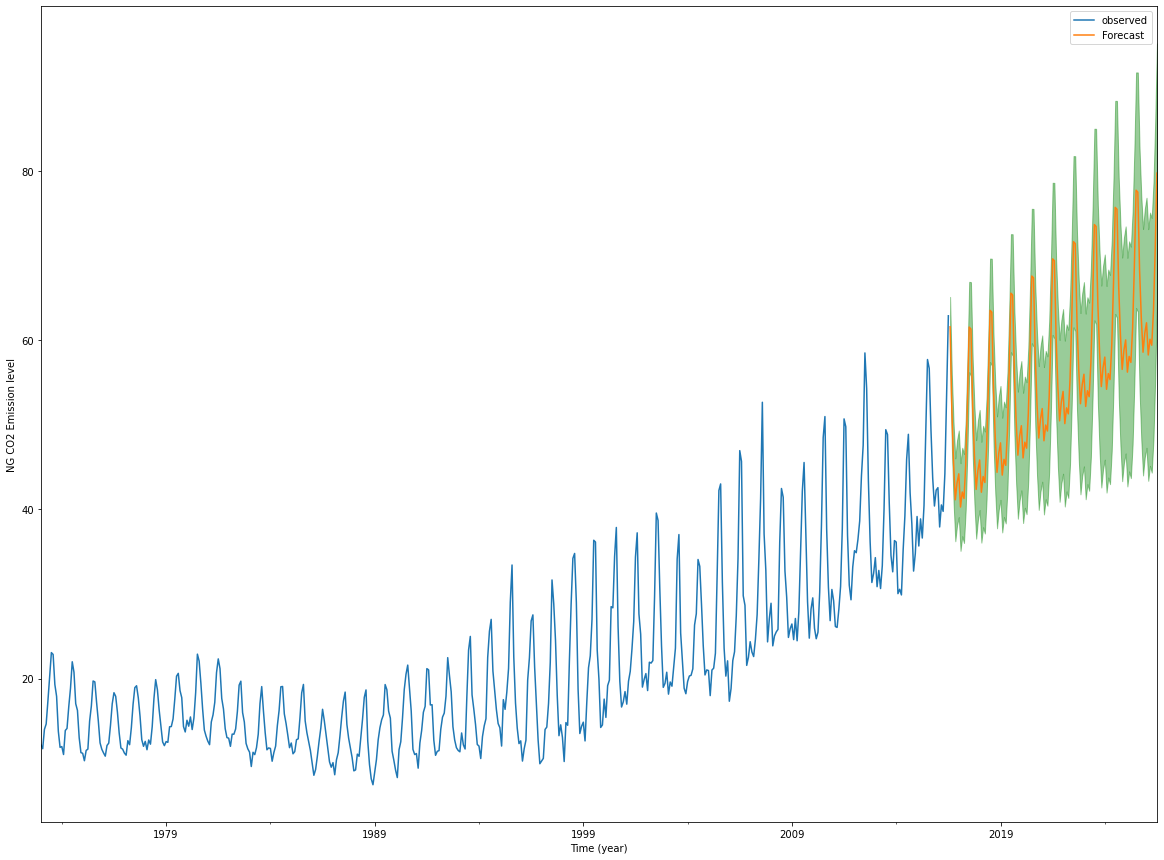

In [53]:
ax = mte.plot(label='observed', figsize=(20, 15))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='g', alpha=.4)
ax.set_xlabel('Time (year)')
ax.set_ylabel('NG CO2 Emission level')

plt.legend()
plt.show()
